In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from p5lib import *
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [2]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [3]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [4]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [5]:
print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [6]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()

scaledX = scaler.fit_transform(tmpX)
print scaledX.shape


(5960, 23)


### Use PCA for dimensional reduction

[  3.27172733e-01   1.23599811e-01   9.71482969e-02   6.85430501e-02
   5.78347093e-02   4.73881578e-02   4.19985272e-02   3.92640360e-02
   3.46822758e-02   2.76923933e-02   2.50142190e-02   2.22809791e-02
   2.20554011e-02   1.60944642e-02   1.16668152e-02   9.24339709e-03
   7.56805099e-03   7.34731055e-03   4.92884099e-03   4.55383044e-03
   2.99018233e-03   6.09843373e-04   3.22675391e-04]


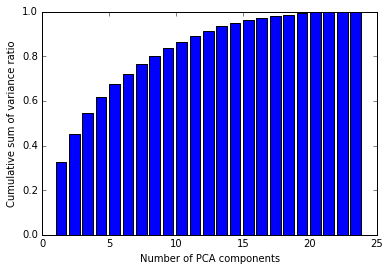

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative sum of variance ratio')
plt.xlabel('Number of PCA components')
plt.show()

In [8]:
pca = PCA(n_components=15)
pca.fit(scaledX)
reducedX = pca.transform(scaledX)

# reducedX is the chosen top PCA components
print reducedX.shape

(5960, 15)


### Add categorical features as one hot encoded

In [9]:
tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print reducedX.shape
print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

finalX = np.concatenate((reducedX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)

print finalX.shape

(5960, 15)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 83)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 83)
(1192, 83)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.525537      0.527989
std       0.233493      0.238209
min       0.000000      0.000000
25%       0.343493      0.333771
50%       0.549032      0.553577
75%       0.712546      0.720962
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.697057     0.698385
std       0.164441     0.169389
min       0.047100     0.019200
25%       0.600000     0.589075
50%       0.711100     0.708300
75%       0.809500     0.820050
max       1.000000     1.000000


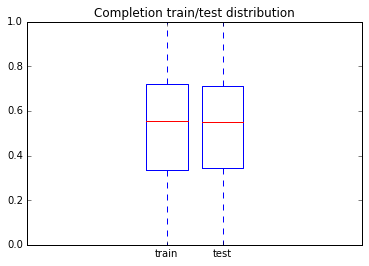

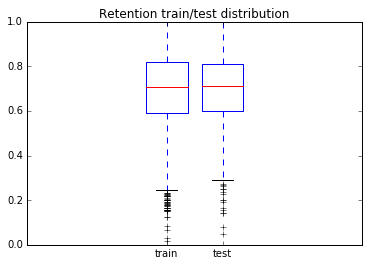

In [10]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


## Build models

X_train contains the following data:
* The first 15 columns are PCA reduced data from the 23 numerical features
* Column 16-19 are one hot encoded categorical data (4 year college, public, private, profit)
* Column 20-83 are one hot encoded remaining caegorical data (Carnegie classifications) 

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 5}
R2 score on train data: 0.59083572333
R2 score on test  data: 0.549993165882
--- R2 Retention ---
best params: {'max_depth': 6}
R2 score on train data: 0.329096352391
R2 score on test  data: 0.253367372287
--- MSE Completion ---
MSE on train data: 0.0232125971128
MSE on test  data: 0.0245133254001
--- MSE Retention ---
MSE on train data: 0.0192460030484
MSE on test  data: 0.0201726319882
--- MAE Completion ---
MAE on train data: 0.113436753833
MAE on test  data: 0.116385224533
--- MAE Retention ---
MAE on train data: 0.0994282518211
MAE on test  data: 0.102627070772


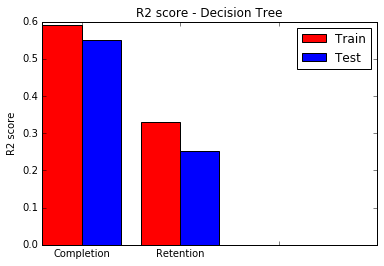

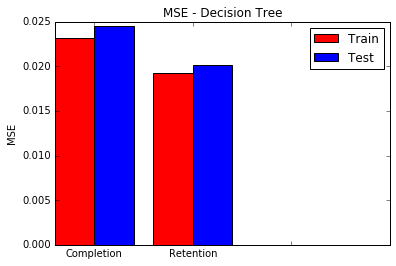

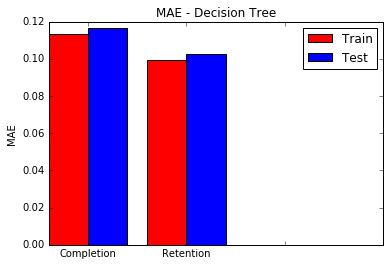

In [11]:
DT19_model = build_DecisionTree_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'max_depth': 7}
R2 score on train data: 0.686551184991
R2 score on test  data: 0.555720280622
--- R2 Retention ---
best params: {'max_depth': 6}
R2 score on train data: 0.328861801785
R2 score on test  data: 0.243792973181
--- MSE Completion ---
MSE on train data: 0.0177824934218
MSE on test  data: 0.0242013509664
--- MSE Retention ---
MSE on train data: 0.0192527315282
MSE on test  data: 0.020431314535
--- MAE Completion ---
MAE on train data: 0.0982679238336
MAE on test  data: 0.113548804301
--- MAE Retention ---
MAE on train data: 0.0994913706569
MAE on test  data: 0.102426469042


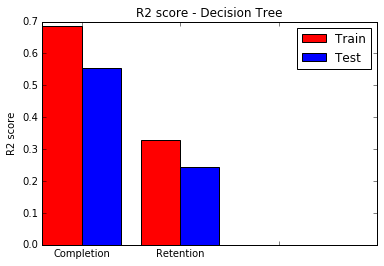

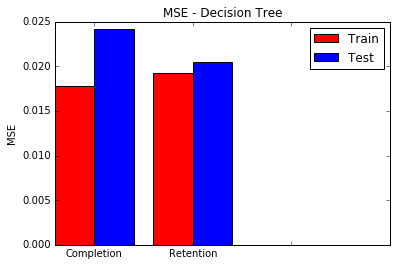

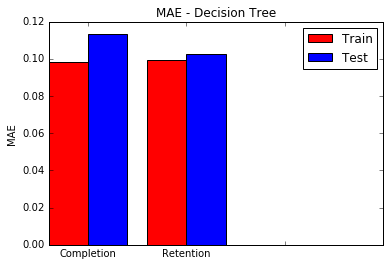

In [12]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.734514653598
R2 score on test  data: 0.652174526941
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.457423781496
R2 score on test  data: 0.335143345822
--- MSE Completion ---
MSE on train data: 0.0150614428893
MSE on test  data: 0.0189471767029
--- MSE Retention ---
MSE on train data: 0.0155647142366
MSE on test  data: 0.0179631965063
--- MAE Completion ---
MAE on train data: 0.0939131866136
MAE on test  data: 0.102312679761
--- MAE Retention ---
MAE on train data: 0.0901144130465
MAE on test  data: 0.0944075645219


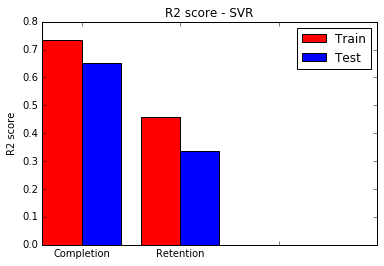

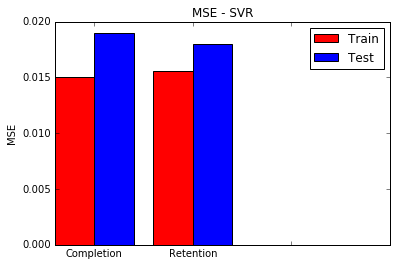

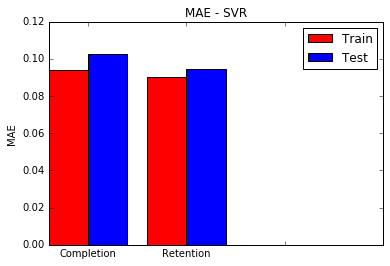

In [13]:
SVR19_model = build_SVR_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.751881784567
R2 score on test  data: 0.658422696367
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.47987211347
R2 score on test  data: 0.334187816587
--- MSE Completion ---
MSE on train data: 0.0140761755109
MSE on test  data: 0.0186068187379
--- MSE Retention ---
MSE on train data: 0.0149207459601
MSE on test  data: 0.017989013138
--- MAE Completion ---
MAE on train data: 0.0912380527182
MAE on test  data: 0.101651284529
--- MAE Retention ---
MAE on train data: 0.0886551104848
MAE on test  data: 0.0948291952358


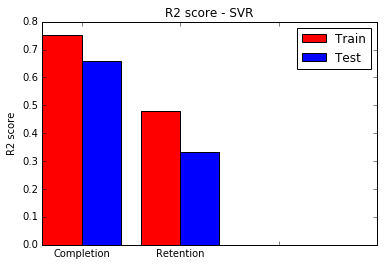

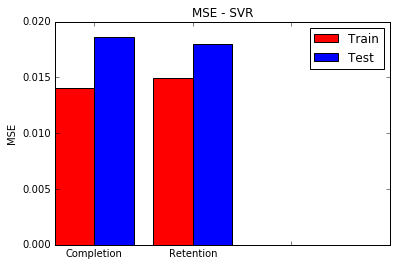

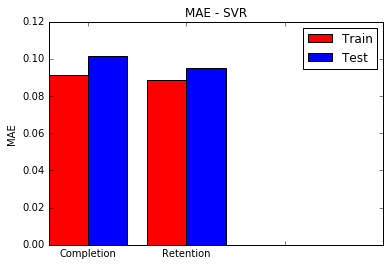

In [14]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

--- R2 Completion ---
best params: {'n_neighbors': 11}
R2 score on train data: 0.724222939179
R2 score on test  data: 0.673219214774
--- R2 Retention ---
best params: {'n_neighbors': 12}
R2 score on train data: 0.427227292073
R2 score on test  data: 0.331993475869
--- MSE Completion ---
MSE on train data: 0.015645309649
MSE on test  data: 0.0178008045999
--- MSE Retention ---
MSE on train data: 0.0164309514818
MSE on test  data: 0.0180483001637
--- MAE Completion ---
MAE on train data: 0.0906571825909
MAE on test  data: 0.0963162441401
--- MAE Retention ---
MAE on train data: 0.090163457774
MAE on test  data: 0.0928440016779


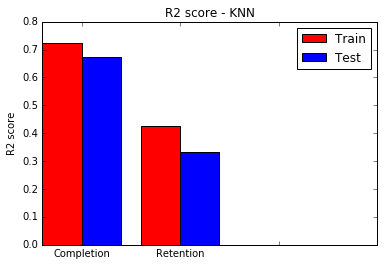

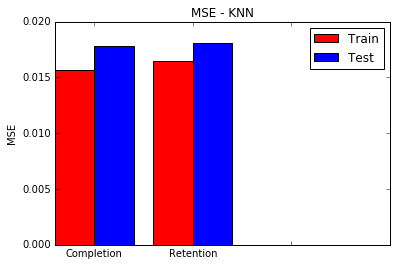

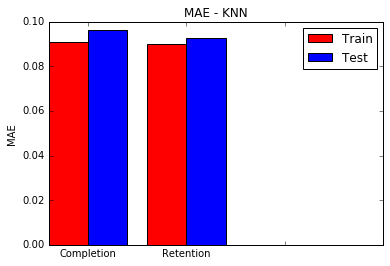

In [15]:
KNN19_model = build_KNN_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'n_neighbors': 10}
R2 score on train data: 0.732165176584
R2 score on test  data: 0.671111853499
--- R2 Retention ---
best params: {'n_neighbors': 13}
R2 score on train data: 0.423133731954
R2 score on test  data: 0.334547612868
--- MSE Completion ---
MSE on train data: 0.015194732784
MSE on test  data: 0.0179155993735
--- MSE Retention ---
MSE on train data: 0.0165483821602
MSE on test  data: 0.0179792921083
--- MAE Completion ---
MAE on train data: 0.0889647234122
MAE on test  data: 0.0966167026647
--- MAE Retention ---
MAE on train data: 0.0901831246773
MAE on test  data: 0.0925436628807


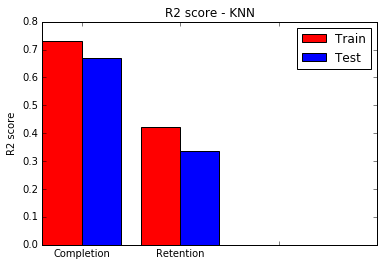

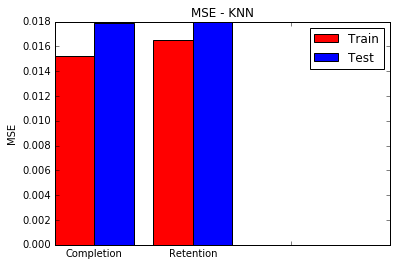

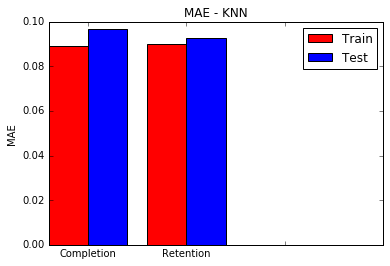

In [16]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

--- R2 Completion ---
R2 score on train data: 0.949412838466
R2 score on test  data: 0.652701958217
--- R2 Retention ---
R2 score on train data: 0.89957748922
R2 score on test  data: 0.342178598578
--- MSE Completion ---
MSE on train data: 0.0028698971702
MSE on test  data: 0.0189184458181
--- MSE Retention ---
MSE on train data: 0.00288078914981
MSE on test  data: 0.0177731169953
--- MAE Completion ---
MAE on train data: 0.0390412800064
MAE on test  data: 0.100015699709
--- MAE Retention ---
MAE on train data: 0.0373676856868
MAE on test  data: 0.0940072703466


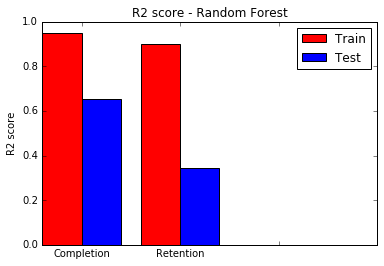

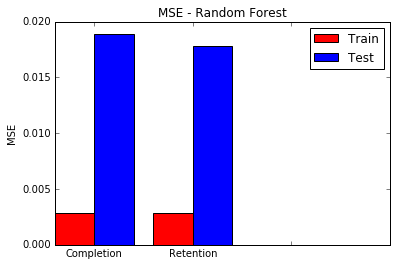

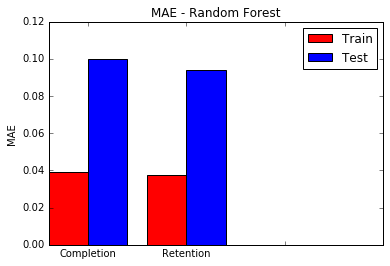

In [17]:
RF19_model = build_RandomForest_model(X_train[:,:19], X_test[:,:19], y_train, y_test, n_estimators=50)

--- R2 Completion ---
R2 score on train data: 0.951410857709
R2 score on test  data: 0.672303410659
--- R2 Retention ---
R2 score on train data: 0.902075094897
R2 score on test  data: 0.342294603589
--- MSE Completion ---
MSE on train data: 0.00275654608277
MSE on test  data: 0.0178506914073
--- MSE Retention ---
MSE on train data: 0.00280914111712
MSE on test  data: 0.0177699827545
--- MAE Completion ---
MAE on train data: 0.0379301935485
MAE on test  data: 0.0971058710988
--- MAE Retention ---
MAE on train data: 0.0368037728504
MAE on test  data: 0.0933745298365


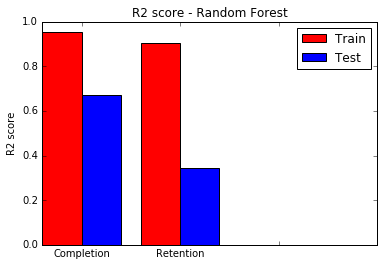

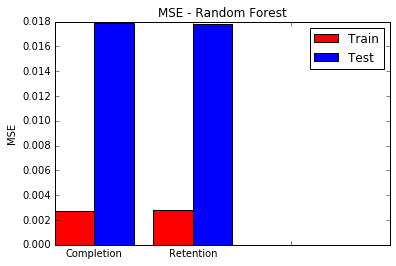

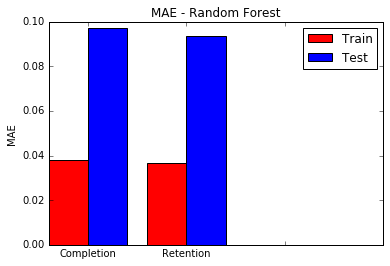

In [18]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

### Comparing R2, MSE and MAE between models with 19 features

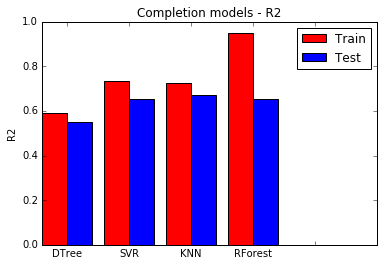

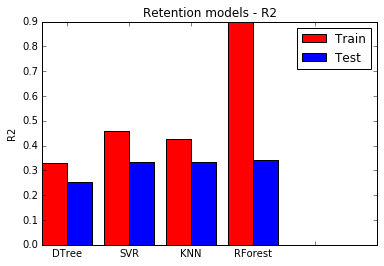

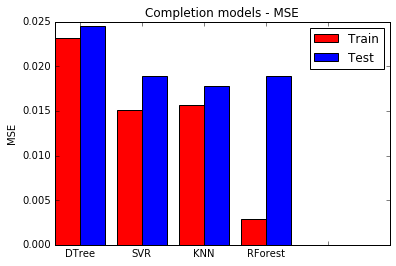

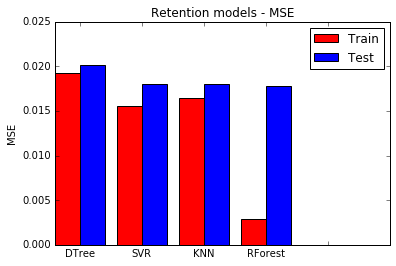

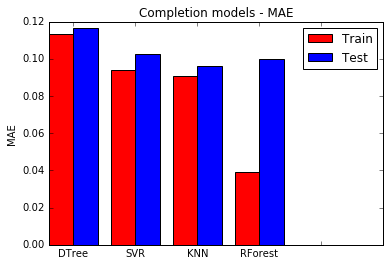

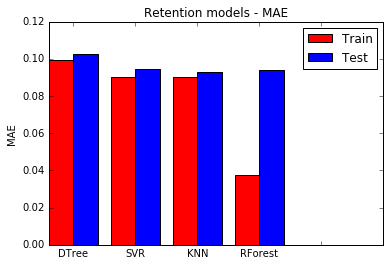

In [19]:
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')
    

### Comparing R2, MSE and MAE between models with 83 features

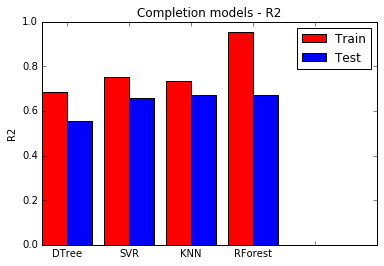

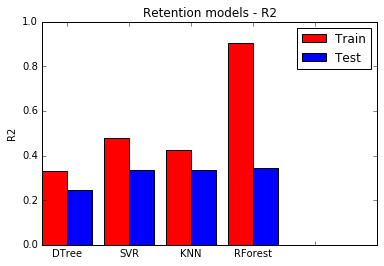

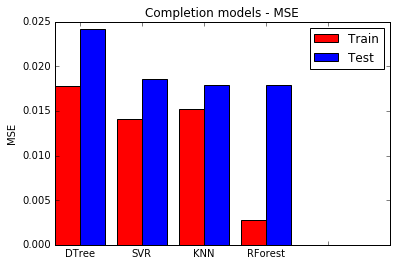

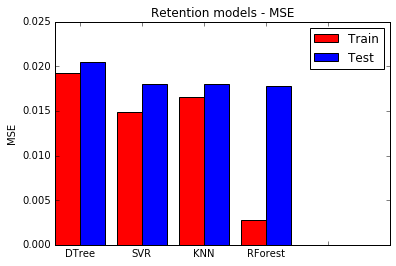

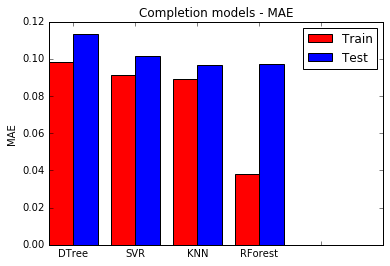

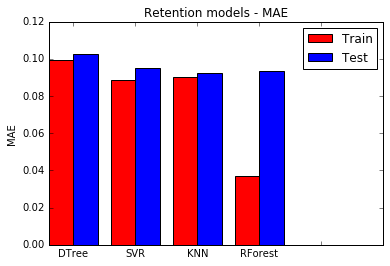

In [20]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Comparing R2, MSE, MAE on test data between models with 19 and 83 features

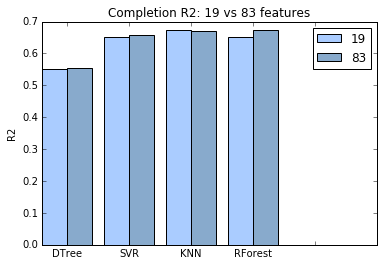

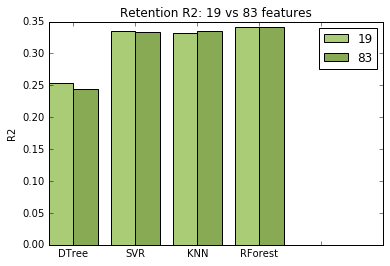

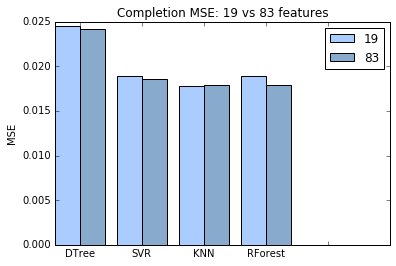

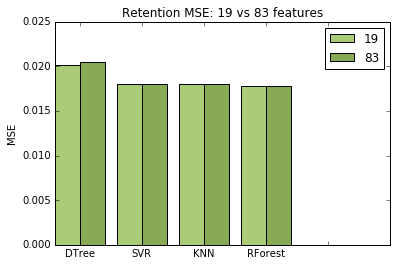

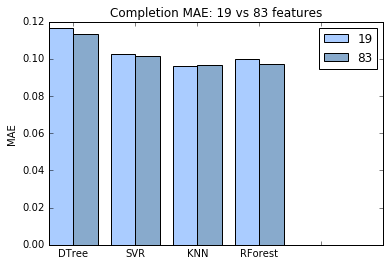

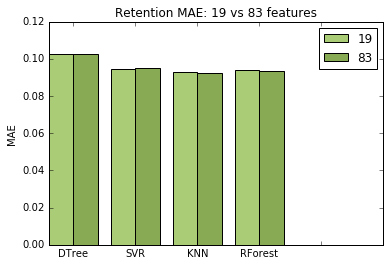

In [21]:
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='r2')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mse')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mae')

### Using Completion model to help predict Retention rate

Because the Completion model has a pretty good r2 score compared to the Retention model, we could use the Completion model to help predict the Retention. This might work because there is a clear positive linear correlation between completion and retention.

For this improvement, the implementation for the completion model is exactly the same. However, the retention model will have one more feature--the completion rate. The retention model is trained using the same X_train + y1_train (the completion rate data). When doing prediction on the test set, the retention model takes the X_test + the predicted completion rate from the completion model.

In [22]:
from sklearn.ensemble import RandomForestRegressor

def print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)
    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2_train_reg2 = print_r2score(reg2, X_train1, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test1, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mse_train_reg2 = print_mse(reg2, X_train1, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mae_train_reg2 = print_mae(reg2, X_train1, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)
    
    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
#     plot_err_metric(r2, metric='R2 score', model='Random Forest nested')
#     plot_err_metric(mse, metric='MSE', model='Random Forest nested')
#     plot_err_metric(mae, metric='MAE', model='Random Forest nested')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

RF_nested = build_RandomForest_model_nested(X_train[:,:19], X_test[:,:19], y_train, y_test)


--- R2 Completion ---
R2 score on train data: 0.949775903788
R2 score on test  data: 0.644274266169
--- R2 Retention ---
R2 score on train data: 0.907780297515
R2 score on test  data: 0.358502261353
--- MSE Completion ---
MSE on train data: 0.00284929984652
MSE on test  data: 0.0193775294184
--- MSE Retention ---
MSE on train data: 0.00264547775446
MSE on test  data: 0.0173320818333
--- MAE Completion ---
MAE on train data: 0.038587094068
MAE on test  data: 0.100845526464
--- MAE Retention ---
MAE on train data: 0.03404634422
MAE on test  data: 0.0925456644832


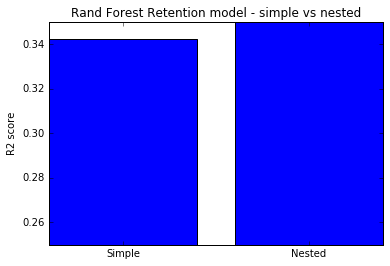

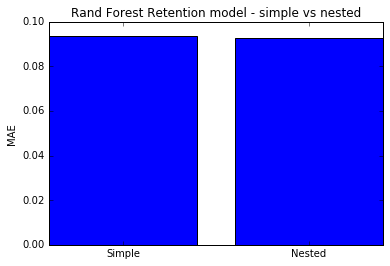

In [23]:
# Comparison of r2 score between simple vs nested model (using RandomForest) 
ret_r2  = [RF_model['r2']['reg2']['test'], RF_nested['r2']['reg2']['test']]
ret_mae  = [RF_model['mae']['reg2']['test'], RF_nested['mae']['reg2']['test']]

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')
plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')
plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### SVR Nested Model

In [24]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_SVR_model_nested(X_train, X_test, y_train, y_test, cv=3, params=None):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    scorer = default_scorer
    reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    reg1.fit(X_train, y1_train)

    reg = SVR()
    reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)

    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)

    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

SVR_nested = build_SVR_model_nested(X_train[:,:19], X_test[:,:19], y_train, y_test)


--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.734514653598
R2 score on test  data: 0.652174526941
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.489068355806
R2 score on test  data: 0.332390574002
--- MSE Completion ---
MSE on train data: 0.0150614428893
MSE on test  data: 0.0189471767029
--- MSE Retention ---
MSE on train data: 0.0146569362333
MSE on test  data: 0.018037571307
--- MAE Completion ---
MAE on train data: 0.0939131866136
MAE on test  data: 0.102312679761
--- MAE Retention ---
MAE on train data: 0.0861847288182
MAE on test  data: 0.0947939555757


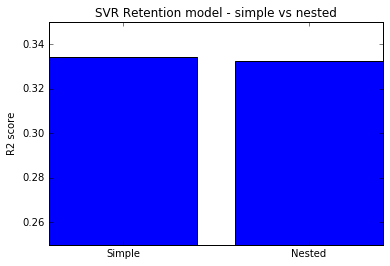

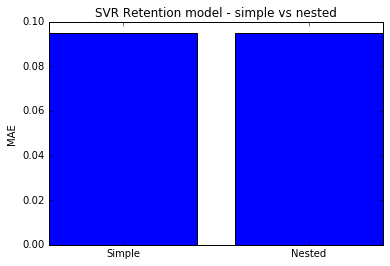

In [25]:
# Comparison of r2 score between simple vs nested model (using SVR model) 
ret_r2  = [SVR_model['r2']['reg2']['test'], SVR_nested['r2']['reg2']['test']]
ret_mae  = [SVR_model['mae']['reg2']['test'], SVR_nested['mae']['reg2']['test']]

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.10, 0.11])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')

plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


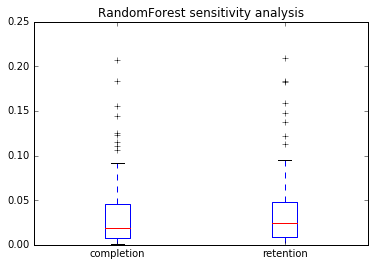

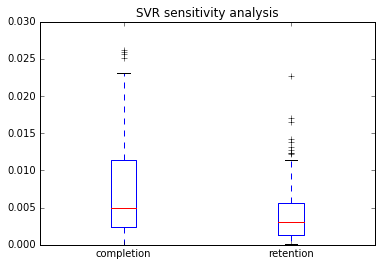

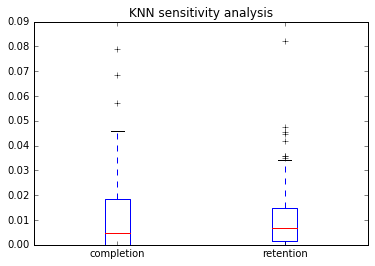

In [26]:

def final_nested_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    X1 = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
    y2_predicted = reg2.predict(X1)
    return y1_predicted, y2_predicted

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


### Prediction error distribution

Metric only goes so far as telling as the mean absolute error, or the R2 score with just one number. 
To get a better idea how our model performs, we'll look at the prediction error on the test data and create histogram of the error distribution, so we can tell what's the percentage the model get it close, and what's the percentage it does really poorly.

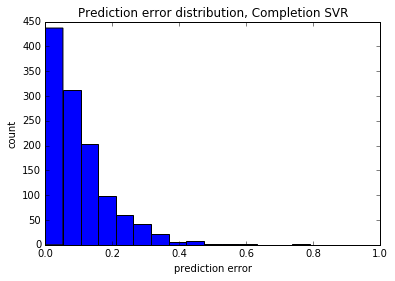

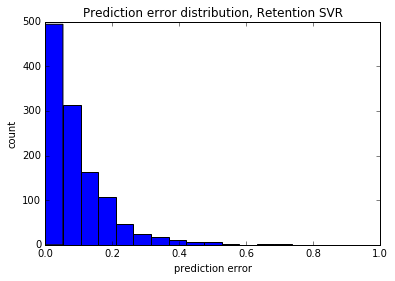

In [27]:
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')

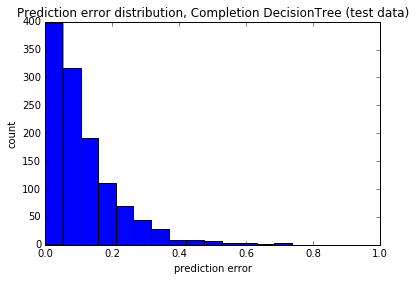

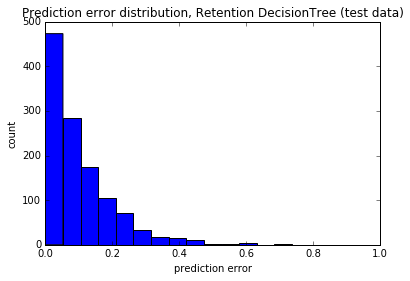

In [28]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')
# hist_plot_delta(DT_model, X_train, y_train, model_name='DecisionTree (train data)')

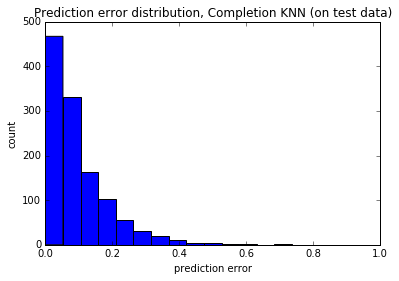

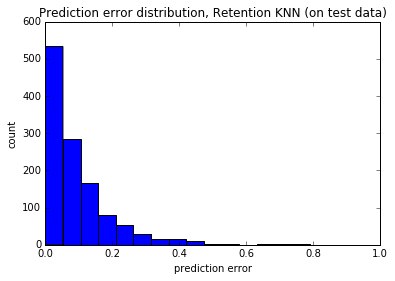

In [29]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')
# hist_plot_delta(KNN_model, X_train, y_train, model_name='KNN (on train data)')

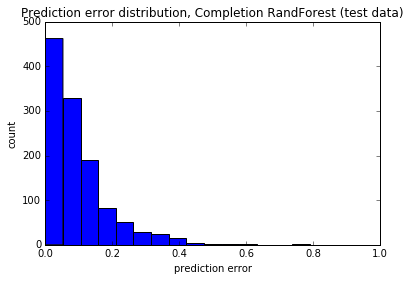

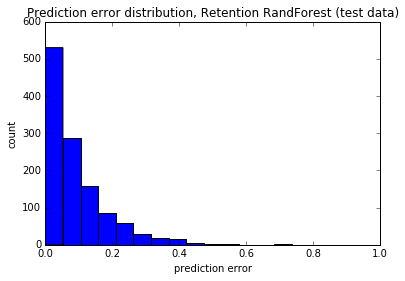

In [30]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')
# hist_plot_delta(RF_model, X_train, y_train, model_name='RandForest (train data)')

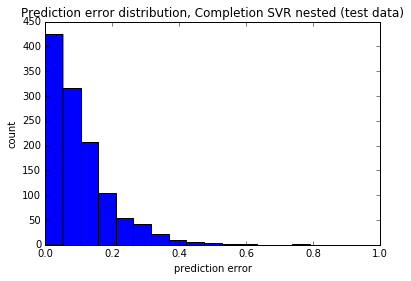

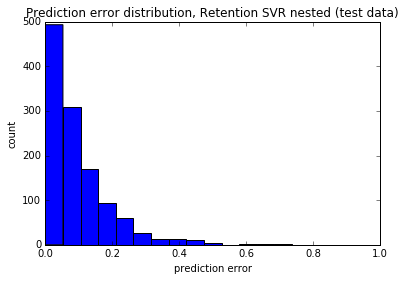

In [31]:
hist_plot_delta(SVR_nested, X_test[:,:19], y_test[:,:19], model_name='SVR nested (test data)', nested=True)
# hist_plot_delta(SVR_nested, X_train, y_train, model_name='SVR nested (train data)')

### Error distribution comparison between models

The following histogram plots show how different models perform. Even though some models have similar R2 and MAE, they don't always make the same prediction. This comparison shows how the models trade off error distribution.

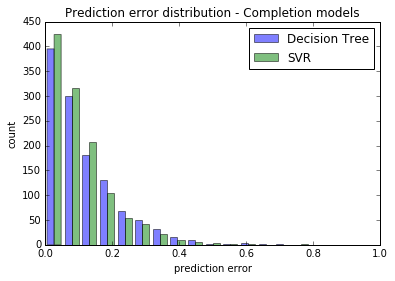

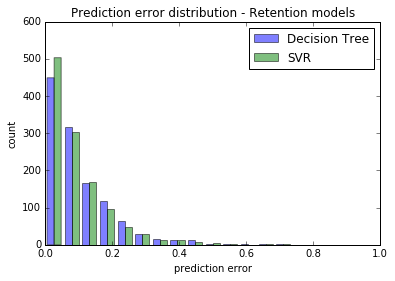

In [32]:
compare_hist_plot_delta(DT19_model, SVR19_model, X_test[:,:19], y_test[:,:19], ['Decision Tree', 'SVR'])

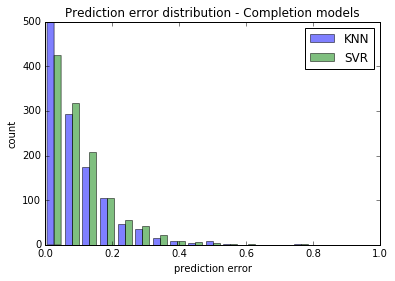

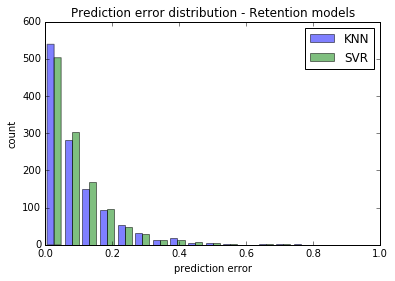

In [33]:
compare_hist_plot_delta(KNN19_model, SVR19_model, X_test[:,:19], y_test[:,:19], ['KNN', 'SVR'])

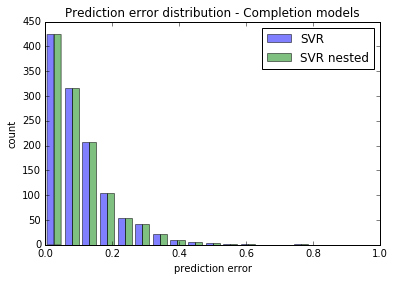

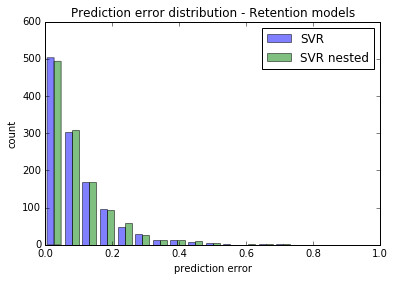

In [34]:
compare_hist_plot_delta(SVR19_model, SVR_nested, X_test[:,:19], y_test[:,:19], ['SVR', 'SVR nested'], nested=[False, True])